# Skill of f3 using sign test

In [61]:
import re
import os
import glob
import doppyo
import itertools
import regionmask
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Notebook specific -----
%matplotlib inline

In [2]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       memory='8GB',
                       walltime='03:00:00')
cluster

/flush4/squ027/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/flush4/squ027/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
from dask.distributed import Client
client = Client(cluster)

In [128]:
saveloc = '/OSM/CBR/OA_DCFP/work/squ027/squire_scratch/projects/HydroTAS/f3_forecast_verification/figures/'

# Notebook functions

In [5]:
lambda_anomalize = lambda data, clim: doppyo.utils.datetime_to_leadtime(
                                          doppyo.utils.anomalize(
                                              doppyo.utils.leadtime_to_datetime(data), clim))

In [6]:
def natural_keys(path):
    basename = os.path.basename(path)
    return [ int(c) for c in re.split('(\d+)', basename) if c.isdigit()]

In [7]:
def cv_anomalize(fcst, clim_ts, leave_out_years=1, time_dim = 'init_date'):
    """ Anomalize provided data in a "cross-validated" manner """
    
    if (leave_out_years % 2) == 0:
        raise ValueError('leave_out_years must be odd')
    
    span = (leave_out_years - 1) / 2
    
    fcst_year = fcst[time_dim].dt.year.item()
    remove_years = np.arange(fcst_year-span, fcst_year+span+1)
    
    clim_dates = clim_ts[time_dim].values
    if not hasattr(clim_dates, "__iter__"):
        clim_dates = [clim_dates]
        
    dates_2_use = [date for date in clim_dates if pd.to_datetime(date).year not in remove_years]
    
    clim = clim_ts.sel({time_dim : dates_2_use}).groupby(time_dim+'.month').mean(time_dim)

    return fcst - clim.sel(month = fcst[time_dim].dt.month.values)

In [8]:
colorsd = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']
colors = colorsd

In [9]:
upper_color = (8 + np.array([0, 0.5, 1])) / 9
lower_color = (8 + np.array([1, 0.5, 0])) / 9

# A note about anomalies
The CMC Can3/4 hindcasts / forecasts span the periods 1981-01 -> 2010-12 / 2011-01 -> 2018-09. The GFDL and COLA models span 1982-01 -> 2018-11. The Hadley ISST data spans 1870-01 -> 2018-02. The f3 hindcasts span 2002-02 -> 2015-12
The mutual span of these datasets is **2002-02 -> 2015-12**

Given the short f3 hindcasts, the only possible approach for calculating anomalies that includes a bias correction is via a (cheating) cross-validation approach (**c1**) : model anomalies over the period **2002-02 -> 2015-12** are computed relative to the (lead-time-dependent) ensemble mean model climatology over the same period using cross-validation - see Kirtman and Min (2009), Kirtman *et al.* (2014)... Similarly, observed anomalies over the period **2002-02 -> 2015-12** are computed relative to the observed climatology over the same period using cross-validation

The anomalies of all models are computed in this way, making for fair comparison between the different models. Note however, than any estimate of absolute skill will be substantially **overestimated**

Biased anomalies are also computed relative to the observed climatology over the period 1970-2000 (**c0**)

# Load the data

In [10]:
compute_data = False # If True, recomputes quantities from raw data and saves to dataloc, otherwise loads from dataloc
dataloc = '/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/'

### Raw Hadley ISST data

In [11]:
if compute_data:
    had_sst_full_ts = xr.open_dataset(dataloc + 'ENSO_predictability.had_sst_raw_ts.nc')['sst'].rename('had')
    had_nino4_full_ts = doppyo.diagnostic.nino4(had_sst_full_ts).rename('had')
    had_nino4_full = doppyo.utils.stack_by_init_date(had_nino4_full_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=24).rename('had')
    
    had_nino4_full_ts.to_netcdf(dataloc + 'HydroTas.had_nino4_full_ts.nc')
    had_nino4_full.to_netcdf(dataloc + 'HydroTas.had_nino4_full.nc')
else:
    had_nino4_full_ts = xr.open_dataset(dataloc + 'HydroTas.had_nino4_full_ts.nc')['had']
    had_nino4_full = xr.open_dataset(dataloc + 'HydroTas.had_nino4_full.nc')['had']

##### compute anomalies

In [12]:
clim_period = slice('1970','2000')
had_clim = had_nino4_full_ts.sel(time=clim_period).groupby('time.month').mean('time')

if compute_data:    
    had_nino4_ts = (had_nino4_full_ts.groupby('time.month') - had_clim).drop('month')
    had_nino4_c0 = doppyo.utils.stack_by_init_date(had_nino4_ts, init_dates=pd.date_range('2002-02','2015-12',freq='MS'), N_lead_steps=24).rename('had_c0')
    
    had_nino4 = had_nino4_c0.to_dataset()

In [13]:
if compute_data:
    clim_period = slice('2002-02','2015')
    clim_use = had_nino4_full_ts.sel(time=clim_period)
    had_nino4_ts = had_nino4_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, leave_out_years=3, time_dim='time')
    had_nino4_c1 = doppyo.utils.stack_by_init_date(had_nino4_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=24).drop('month').rename('had_c1')
    
    had_nino4['had_c1'] = had_nino4_c1  

In [14]:
if compute_data:
    had_nino4.to_netcdf(dataloc + 'HydroTas.had_nino4.nc')
else:
    had_nino4 = xr.open_dataset(dataloc + 'HydroTas.had_nino4.nc')

### JRA precip data

In [16]:
if compute_data:
    obs_filepath = '/OSM/CBR/OA_DCFP/data/observations/JRA55/isobaric/'
    obs_names = ['061_tprat/cat/jra.55.tprat.000.1958010100_2016123121.nc','TPRAT_GDS0_SFC_ave3h']

    jra_precip_full_ts = xr.open_dataset(obs_filepath + obs_names[0], use_cftime=False)[obs_names[1]] \
                           .rename({'g0_lat_2':'lat', 'g0_lon_3':'lon', 'initial_time0_hours':'time'}) \
                           .mean('forecast_time1').resample({'time' : 'MS'}).sum('time').rename('jra')
    jra_precip_full = doppyo.utils.stack_by_init_date(jra_precip_full_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=24).rename('jra')

    jra_precip_full_ts.to_netcdf(dataloc + 'HydroTas.jra_precip_full_ts.nc')
    jra_precip_full.to_netcdf(dataloc + 'HydroTas.jra_precip_full.nc')
else:
    jra_precip_full_ts = xr.open_dataset(dataloc + 'HydroTas.jra_precip_full_ts.nc')['jra']
    jra_precip_full = xr.open_dataset(dataloc + 'HydroTas.jra_precip_full.nc')['jra']

##### compute anomalies

In [17]:
clim_period = slice('1970','2000')
jra_clim = jra_precip_full_ts.sel(time=clim_period).groupby('time.month').mean('time')

if compute_data:    
    jra_precip_ts = (jra_precip_full_ts.groupby('time.month') - jra_clim).drop('month')
    jra_precip_c0 = doppyo.utils.stack_by_init_date(jra_precip_ts, init_dates=pd.date_range('2002-02','2015-12',freq='MS'), N_lead_steps=24).rename('jra_c0')
    
    jra_precip = jra_precip_c0.to_dataset()

In [18]:
if compute_data:
    clim_period = slice('2002-02','2015')
    clim_use = jra_precip_full_ts.sel(time=clim_period)
    jra_precip_ts = jra_precip_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, leave_out_years=3, time_dim='time')
    jra_precip_c1 = doppyo.utils.stack_by_init_date(jra_precip_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=24).drop('month').rename('jra_c1')
    
    jra_precip['jra_c1'] = jra_precip_c1  

In [19]:
if compute_data:
    jra_precip.to_netcdf(dataloc + 'HydroTas.jra_precip.nc')
else:
    jra_precip = xr.open_dataset(dataloc + 'HydroTas.jra_precip.nc')

### Raw COLA-RSMAS-CCSM4 data

In [22]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/COLA-RSMAS-CCSM4/monthly/sst_mon_COLA-RSMAS-CCSM4_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    cola_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(cola_sst_raw.init_date.units.split(' ')[2])
    cola_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cola_sst_raw.init_date.values])

    cola_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cola_sst_raw['lead_time']]
    cola_sst_raw.lead_time.attrs['units'] = 'MS'

    cola_sst_raw['ensemble'] = [int(ensemble) for ensemble in cola_sst_raw['ensemble']]

##### Compute nino3.4

In [23]:
if compute_data:
    cola_nino4_full = doppyo.diagnostic.nino4(cola_sst_raw).rename('cola')
    
    cola_nino4_full.to_netcdf(dataloc + 'HydroTas.cola_nino4_full.nc')
else:
    cola_nino4_full = xr.open_dataset(dataloc + 'HydroTas.cola_nino4_full.nc')['cola']

##### compute anomalies

In [24]:
if compute_data:
    cola_nino4_c0 = cola_nino4_full.groupby('init_date').apply(lambda_anomalize, clim=had_clim).rename('cola_c0')
    
    cola_nino4 = cola_nino4_c0.to_dataset()

In [25]:
if compute_data:
    clim_period = slice('2002','2015')
    cola_nino4_full_use = cola_nino4_full.sel(init_date=clim_period).mean('ensemble')
    cola_nino4_c1 = cola_nino4_full.groupby('init_date').apply(cv_anomalize, clim_ts=cola_nino4_full_use, leave_out_years=3).rename('cola_c1')
    
    cola_nino4['cola_c1'] = cola_nino4_c1

In [26]:
if compute_data:
    cola_nino4.to_netcdf(dataloc + 'HydroTas.cola_nino4.nc')
else:
    cola_nino4 = xr.open_dataset(dataloc + 'HydroTas.cola_nino4.nc')

### Raw GFDL-CM2p1-aer04 data

In [27]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p1-aer04/monthly/sst_mon_GFDL-CM2p1-aer04_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    aer04_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute() - 273.15

    basedate = np.datetime64(aer04_sst_raw.init_date.units.split(' ')[2])
    aer04_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in aer04_sst_raw.init_date.values])

    aer04_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in aer04_sst_raw['lead_time']]
    aer04_sst_raw.lead_time.attrs['units'] = 'MS'

    aer04_sst_raw['ensemble'] = [int(ensemble) for ensemble in aer04_sst_raw['ensemble']]

##### Compute nino3.4

In [28]:
if compute_data:
    aer04_nino4_full = doppyo.diagnostic.nino4(aer04_sst_raw).rename('aer04')
    
    aer04_nino4_full.to_netcdf(dataloc + 'HydroTas.aer04_nino4_full.nc')
else:
    aer04_nino4_full = xr.open_dataset(dataloc + 'HydroTas.aer04_nino4_full.nc')['aer04']

##### compute anomalies

In [29]:
if compute_data:
    aer04_nino4_c0 = aer04_nino4_full.groupby('init_date').apply(lambda_anomalize, clim=had_clim).rename('aer04_c0')
    
    aer04_nino4 = aer04_nino4_c0.to_dataset()

In [30]:
if compute_data:
    clim_period = slice('2002','2015')
    aer04_nino4_full_use = aer04_nino4_full.sel(init_date=clim_period).mean('ensemble')
    aer04_nino4_c1 = aer04_nino4_full.groupby('init_date').apply(cv_anomalize, clim_ts=aer04_nino4_full_use, leave_out_years=3).rename('aer04_c1')
    
    aer04_nino4['aer04_c1'] = aer04_nino4_c1

In [31]:
if compute_data:
    aer04_nino4.to_netcdf(dataloc + 'HydroTas.aer04_nino4.nc')
else:
    aer04_nino4 = xr.open_dataset(dataloc + 'HydroTas.aer04_nino4.nc')

### Raw GFDL-CM2p5-FLOR-A06 data

In [32]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p5-FLOR-A06/monthly/sst_mon_GFDL-CM2p5-FLOR-A06_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    florA_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(florA_sst_raw.init_date.units.split(' ')[2])
    florA_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in florA_sst_raw.init_date.values])

    florA_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in florA_sst_raw['lead_time']]
    florA_sst_raw.lead_time.attrs['units'] = 'MS'

    florA_sst_raw['ensemble'] = [int(ensemble) for ensemble in florA_sst_raw['ensemble']]

##### Compute nino3.4

In [33]:
if compute_data:
    florA_nino4_full = doppyo.diagnostic.nino4(florA_sst_raw).rename('florA')
    
    florA_nino4_full.to_netcdf(dataloc + 'HydroTas.florA_nino4_full.nc')
else:
    florA_nino4_full = xr.open_dataset(dataloc + 'HydroTas.florA_nino4_full.nc')['florA']

##### compute anomalies

In [34]:
if compute_data:
    florA_nino4_c0 = florA_nino4_full.groupby('init_date').apply(lambda_anomalize, clim=had_clim).rename('florA_c0')
    
    florA_nino4 = florA_nino4_c0.to_dataset()

In [35]:
if compute_data:
    clim_period = slice('2002','2015')
    florA_nino4_full_use = florA_nino4_full.sel(init_date=clim_period).mean('ensemble')
    florA_nino4_c1 = florA_nino4_full.groupby('init_date').apply(cv_anomalize, clim_ts=florA_nino4_full_use, leave_out_years=3).rename('florA_c1')
    
    florA_nino4['florA_c1'] = florA_nino4_c1

In [36]:
if compute_data:
    florA_nino4.to_netcdf(dataloc + 'HydroTas.florA_nino4.nc')
else:
    florA_nino4 = xr.open_dataset(dataloc + 'HydroTas.florA_nino4.nc')

### Raw GFDL-CM2p5-FLOR-B01 data

In [37]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p5-FLOR-B01/monthly/sst_mon_GFDL-CM2p5-FLOR-B01_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    florB_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(florB_sst_raw.init_date.units.split(' ')[2])
    florB_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in florB_sst_raw.init_date.values])

    florB_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in florB_sst_raw['lead_time']]
    florB_sst_raw.lead_time.attrs['units'] = 'MS'

    florB_sst_raw['ensemble'] = [int(ensemble) for ensemble in florB_sst_raw['ensemble']]

##### Compute nino3.4

In [38]:
if compute_data:
    florB_nino4_full = doppyo.diagnostic.nino4(florB_sst_raw).rename('florB')

    florB_nino4_full.to_netcdf(dataloc + 'HydroTas.florB_nino4_full.nc')
else:
    florB_nino4_full = xr.open_dataset(dataloc + 'HydroTas.florB_nino4_full.nc')['florB']

##### compute anomalies

In [39]:
if compute_data:
    florB_nino4_c0 = florB_nino4_full.groupby('init_date').apply(lambda_anomalize, clim=had_clim).rename('florB_c0')
    
    florB_nino4 = florB_nino4_c0.to_dataset()

In [40]:
if compute_data:
    clim_period = slice('2002','2015')
    florB_nino4_full_use = florB_nino4_full.sel(init_date=clim_period).mean('ensemble')
    florB_nino4_c1 = florB_nino4_full.groupby('init_date').apply(cv_anomalize, clim_ts=florB_nino4_full_use, leave_out_years=3).rename('florB_c1')
    
    florB_nino4['florB_c1'] = florB_nino4_c1

In [41]:
if compute_data:
    florB_nino4.to_netcdf(dataloc + 'HydroTas.florB_nino4.nc')
else:
    florB_nino4 = xr.open_dataset(dataloc + 'HydroTas.florB_nino4.nc')

### Raw CMC CanCM3 data

In [42]:
if compute_data:
    folder = '/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/CMC_CanCM3/monthly/'
    hcstfiles = 'sst_mon_CanCM3_198101*.nc'
    fcstfiles = 'sst_mon_CanCM3_201101*.nc'

    hcstlist = glob.glob(folder + hcstfiles)
    hcstlist.sort(key=natural_keys)
    fcstlist = glob.glob(folder + fcstfiles)
    fcstlist.sort(key=natural_keys)

    cm3_sst_raw = xr.concat([xr.open_mfdataset(hcstlist, decode_times=False)['sst'] - 273.15,
                             xr.open_mfdataset(fcstlist, decode_times=False)['sst'] - 273.15], dim='S') \
                    .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                             'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(cm3_sst_raw.init_date.units.split(' ')[2])
    cm3_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cm3_sst_raw.init_date.values])

    cm3_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cm3_sst_raw['lead_time']]
    cm3_sst_raw.lead_time.attrs['units'] = 'MS'

    cm3_sst_raw['ensemble'] = [int(ensemble) for ensemble in cm3_sst_raw['ensemble']]

##### Compute nino3.4

In [43]:
if compute_data:
    cm3_nino4_full = doppyo.diagnostic.nino4(cm3_sst_raw).rename('cm3')

    cm3_nino4_full.to_netcdf(dataloc + 'HydroTas.cm3_nino4_full.nc')
else:
    cm3_nino4_full = xr.open_dataset(dataloc + 'HydroTas.cm3_nino4_full.nc')['cm3']

##### compute anomalies

In [44]:
if compute_data:
    cm3_nino4_c0 = cm3_nino4_full.groupby('init_date').apply(lambda_anomalize, clim=had_clim).rename('cm3_c0')
    
    cm3_nino4 = cm3_nino4_c0.to_dataset()

In [45]:
if compute_data:
    clim_period = slice('2002','2015')
    cm3_nino4_full_use = cm3_nino4_full.sel(init_date=clim_period).mean('ensemble')
    cm3_nino4_c1 = cm3_nino4_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm3_nino4_full_use, leave_out_years=3).rename('cm3_c1')
    
    cm3_nino4['cm3_c1'] = cm3_nino4_c1

In [46]:
if compute_data:
    cm3_nino4.to_netcdf(dataloc + 'HydroTas.cm3_nino4.nc')
else:
    cm3_nino4 = xr.open_dataset(dataloc + 'HydroTas.cm3_nino4.nc')

### Raw CMC CanCM4 data

In [50]:
if compute_data:
    folder = '/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/CMC_CanCM4/monthly/'
    hcstfiles = 'sst_mon_CanCM4_198101*.nc'
    fcstfiles = 'sst_mon_CanCM4_201101*.nc'

    hcstlist = glob.glob(folder + hcstfiles)
    hcstlist.sort(key=natural_keys)
    fcstlist = glob.glob(folder + fcstfiles)
    fcstlist.sort(key=natural_keys)

    cm4_sst_raw = xr.concat([xr.open_mfdataset(hcstlist, decode_times=False)['sst'] - 273.15,
                             xr.open_mfdataset(fcstlist, decode_times=False)['sst'] - 273.15], dim='S') \
                    .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                             'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(cm4_sst_raw.init_date.units.split(' ')[2])
    cm4_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cm4_sst_raw.init_date.values])

    cm4_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cm4_sst_raw['lead_time']]
    cm4_sst_raw.lead_time.attrs['units'] = 'MS'

    cm4_sst_raw['ensemble'] = [int(ensemble) for ensemble in cm4_sst_raw['ensemble']]

##### Compute nino3.4

In [51]:
if compute_data:
    cm4_nino4_full = doppyo.diagnostic.nino4(cm4_sst_raw).rename('cm4')

    cm4_nino4_full.to_netcdf(dataloc + 'HydroTas.cm4_nino4_full.nc')
else:
    cm4_nino4_full = xr.open_dataset(dataloc + 'HydroTas.cm4_nino4_full.nc')['cm4']

##### compute anomalies

In [52]:
if compute_data:
    cm4_nino4_c0 = cm4_nino4_full.groupby('init_date').apply(lambda_anomalize, clim=had_clim).rename('cm4_c0')
    
    cm4_nino4 = cm4_nino4_c0.to_dataset()

In [53]:
if compute_data:
    clim_period = slice('2002','2015')
    cm4_nino4_full_use = cm4_nino4_full.sel(init_date=clim_period).mean('ensemble')
    cm4_nino4_c1 = cm4_nino4_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm4_nino4_full_use, leave_out_years=3).rename('cm4_c1')
    
    cm4_nino4['cm4_c1'] = cm4_nino4_c1

In [54]:
if compute_data:
    cm4_nino4.to_netcdf(dataloc + 'HydroTas.cm4_nino4.nc')
else:
    cm4_nino4 = xr.open_dataset(dataloc + 'HydroTas.cm4_nino4.nc')

### Raw CAFE f3 forecast data

#### SST

In [70]:
if compute_data:
    fcst_filepath = '/OSM/CBR/OA_DCFP/data2/model_output/CAFE/forecasts/f3'
    fcst_filename = 'ocean_month*.nc'

    init_dates = pd.date_range('2002-02','2015-12' , freq='1MS')
    ensembles = range(1, 12) 

    # Generate list of paths and coordinates to create -----
    paths = [({'init_date' : i, 'ensemble' : e}, sorted(glob.glob(fcst_filepath + '/yr' + str(i.year) + 
                                                                             '/mn' + str(i.month) + 
                                                                             '/OUTPUT.' + str(e) + '/' + fcst_filename)))
             for i,e in itertools.product(init_dates, ensembles)]
    
    f3_sst_raw = doppyo.sugar.load_and_concat(paths, variables='temp', convert_time_to_lead=True, clip_time_at=2*12, **{'decode_coords':False}) \
                             .isel(st_ocean=0, drop=True).rename('f3')
    # Adjust lead time units attribute to be correct -----
    f3_sst_raw.lead_time.attrs['units'] = 'MS'

##### Compute nino3.4

In [71]:
if compute_data:
    f3_nino4_full = doppyo.diagnostic.nino4(f3_sst_raw).rename('f3').compute()

    f3_nino4_full.to_netcdf(dataloc + 'HydroTas.f3_nino4_full.nc')
else:
    f3_nino4_full = xr.open_dataset(dataloc + 'HydroTas.f3_nino4_full.nc')['f3']

##### compute anomalies

In [72]:
if compute_data:
    f3_nino4_c0 = f3_nino4_full.groupby('init_date').apply(lambda_anomalize, clim=had_clim).rename('f3_c0')
    
    f3_nino4 = f3_nino4_c0.to_dataset()

In [73]:
if compute_data:
    clim_period = slice('2002','2015')
    f3_nino4_full_use = f3_nino4_full.sel(init_date=clim_period).mean('ensemble')
    f3_nino4_c1 = f3_nino4_full.groupby('init_date').apply(cv_anomalize, clim_ts=f3_nino4_full_use, leave_out_years=3).rename('f3_c1')
    
    f3_nino4['f3_c1'] = f3_nino4_c1

In [74]:
if compute_data:
    f3_nino4.to_netcdf(dataloc + 'HydroTas.f3_nino4.nc')
else:
    f3_nino4 = xr.open_dataset(dataloc + 'HydroTas.f3_nino4.nc')

#### Precipitation

In [75]:
if compute_data:
    fcst_filepath = '/OSM/CBR/OA_DCFP/data2/model_output/CAFE/forecasts/f3'
    fcst_filename = 'atmos_daily*.nc'

    init_dates = pd.date_range('2002-02','2015-12' , freq='1MS')
    ensembles = range(1, 12) 

    # Generate list of paths and coordinates to create -----
    paths = [({'init_date' : i, 'ensemble' : e}, sorted(glob.glob(fcst_filepath + '/yr' + str(i.year) + 
                                                                             '/mn' + str(i.month) + 
                                                                             '/OUTPUT.' + str(e) + '/' + fcst_filename)))
             for i,e in itertools.product(init_dates, ensembles)]
    
    f3_precip_raw = doppyo.sugar.load_and_concat(paths, variables='precip', resample_time_like=['MS','sum'], convert_time_to_lead=True, 
                                                 clip_time_at=24, **{'decode_coords':False}).rename('f3') * 60 * 60 * 24 / 998.2 * 1000

In [76]:
if compute_data:
    f3_precip_full = f3_precip_raw.compute()

    f3_precip_full.to_netcdf(dataloc + 'HydroTas.f3_precip_full.nc')
else:
    f3_precip_full = xr.open_dataset(dataloc + 'HydroTas.f3_precip_full.nc')['f3']

##### mask Australia

In [77]:
mask = regionmask.defined_regions.natural_earth.countries_110.mask(f3_precip_full, wrap_lon=True)
f3_precip_Aus_full = f3_precip_full.where(mask == regionmask.defined_regions.natural_earth.countries_110.map_keys('AU'), drop=True)

##### compute anomalies

In [78]:
if compute_data:
    jra_clim_interp = jra_clim.interp(lat=f3_precip_Aus_full.lat, lon=f3_precip_Aus_full.lon)
    f3_precip_Aus_c0 = f3_precip_Aus_full.groupby('init_date').apply(lambda_anomalize, clim=jra_clim_interp).rename('f3_c0')
    
    f3_precip = f3_precip_Aus_c0.to_dataset()

In [79]:
if compute_data:
    clim_period = slice('2002','2015')
    f3_precip_Aus_full_use = f3_precip_Aus_full.sel(init_date=clim_period).mean('ensemble')
    f3_precip_Aus_c1 = f3_precip_Aus_full.groupby('init_date').apply(cv_anomalize, clim_ts=f3_precip_Aus_full_use, leave_out_years=3).rename('f3_c1')
    
    f3_precip['f3_c1'] = f3_precip_Aus_c1

In [80]:
if compute_data:
    f3_precip.to_netcdf(dataloc + 'HydroTas.f3_precip_Aus.nc')
else:
    f3_precip = xr.open_dataset(dataloc + 'HydroTas.f3_precip_Aus.nc')

### Raw CAFE f1 forecast data

#### SST

In [83]:
if compute_data:
    fcst_filepath = '/OSM/CBR/OA_DCFP/data1/model_output/CAFE/forecasts/f1'
    fcst_filename = 'ocean_month*.nc'

    init_dates = pd.date_range('2002-02','2015-12' , freq='1MS')
    ensembles = range(1, 12) 

    # Generate list of paths and coordinates to create -----
    paths = [({'init_date' : i, 'ensemble' : e}, sorted(glob.glob(fcst_filepath + '/yr' + str(i.year) + 
                                                                             '/mn' + str(i.month) + 
                                                                             '/OUTPUT.' + str(e) + '/' + fcst_filename)))
             for i,e in itertools.product(init_dates, ensembles)]
    
    f1_sst_raw = doppyo.sugar.load_and_concat(paths, variable='temp', convert_time_to_lead=True, clip_time_at=2*12, **{'decode_coords':False}) \
                             .isel(st_ocean=0, drop=True).rename('f1')
    # Adjust lead time units attribute to be correct -----
    f1_sst_raw.lead_time.attrs['units'] = 'MS'

##### Compute nino3.4

In [84]:
if compute_data:
    f1_nino4_full = doppyo.diagnostic.nino4(f1_sst_raw).rename('f1').compute()

    f1_nino4_full.to_netcdf(dataloc + 'HydroTas.f1_nino4_full.nc')
else:
    f1_nino4_full = xr.open_dataset(dataloc + 'HydroTas.f1_nino4_full.nc')['f1']

##### compute anomalies

In [85]:
if compute_data:
    f1_nino4_c0 = f1_nino4_full.groupby('init_date').apply(lambda_anomalize, clim=had_clim).rename('f1_c0')
    
    f1_nino4 = f1_nino4_c0.to_dataset()

In [86]:
if compute_data:
    clim_period = slice('2002','2015')
    f1_nino4_full_use = f1_nino4_full.sel(init_date=clim_period).mean('ensemble')
    f1_nino4_c1 = f1_nino4_full.groupby('init_date').apply(cv_anomalize, clim_ts=f1_nino4_full_use, leave_out_years=3).rename('f1_c1')
    
    f1_nino4['f1_c1'] = f1_nino4_c1

In [87]:
if compute_data:
    f1_nino4.to_netcdf(dataloc + 'HydroTas.f1_nino4.nc')
else:
    f1_nino4 = xr.open_dataset(dataloc + 'HydroTas.f1_nino4.nc')

#### Precipitation

In [88]:
if compute_data:
    fcst_filepath = '/OSM/CBR/OA_DCFP/data1/model_output/CAFE/forecasts/f1'
    fcst_filename = 'atmos_daily*.plevel.nc'

    init_dates = pd.date_range('2002-02','2015-12' , freq='1MS')
    ensembles = range(1, 12) 

    # Generate list of paths and coordinates to create -----
    paths = [({'init_date' : i, 'ensemble' : e}, sorted(glob.glob(fcst_filepath + '/yr' + str(i.year) + 
                                                                             '/mn' + str(i.month) + 
                                                                             '/OUTPUT.' + str(e) + '/' + fcst_filename)))
             for i,e in itertools.product(init_dates, ensembles)]
    
    f1_precip_raw = doppyo.sugar.load_and_concat(paths, variables='precip', resample_time_like=['MS','sum'], convert_time_to_lead=True, 
                                                 clip_time_at=24, **{'decode_coords':False, 'use_cftime':True}).rename('f1') * 60 * 60 * 24 / 998.2 * 1000

In [89]:
if compute_data:
    f1_precip_full = f1_precip_raw.compute()

    f1_precip_full.to_netcdf(dataloc + 'HydroTas.f1_precip_full.nc')
else:
    f1_precip_full = xr.open_dataset(dataloc + 'HydroTas.f1_precip_full.nc')['f1']

##### mask Australia

In [90]:
mask = regionmask.defined_regions.natural_earth.countries_110.mask(f1_precip_full, wrap_lon=True)
f1_precip_Aus_full = f1_precip_full.where(mask == regionmask.defined_regions.natural_earth.countries_110.map_keys('AU'), drop=True)

##### compute anomalies

In [91]:
if compute_data:
    jra_clim_interp = jra_clim.interp(lat=f1_precip_Aus_full.lat, lon=f1_precip_Aus_full.lon)
    f1_precip_Aus_c0 = f1_precip_Aus_full.groupby('init_date').apply(lambda_anomalize, clim=jra_clim_interp).rename('f1_c0')
    
    f1_precip = f1_precip_Aus_c0.to_dataset()

In [92]:
if compute_data:
    clim_period = slice('2002','2015')
    f1_precip_Aus_full_use = f1_precip_Aus_full.sel(init_date=clim_period).mean('ensemble')
    f1_precip_Aus_c1 = f1_precip_Aus_full.groupby('init_date').apply(cv_anomalize, clim_ts=f1_precip_Aus_full_use, leave_out_years=3).rename('f1_c1')
    
    f1_precip['f1_c1'] = f1_precip_Aus_c1

In [93]:
if compute_data:
    f1_precip.to_netcdf(dataloc + 'HydroTas.f1_precip_Aus.nc')
else:
    f1_precip = xr.open_dataset(dataloc + 'HydroTas.f1_precip_Aus.nc')

# Make sure that we are using the same number of members for each model

In [94]:
n_members = 10
cola_nino4 = cola_nino4.sel(ensemble = np.arange(1,n_members+1))
aer04_nino4 = aer04_nino4.sel(ensemble = np.arange(1,n_members+1))
florA_nino4 = florA_nino4.sel(ensemble = np.arange(1,n_members+1))
florB_nino4 = florB_nino4.sel(ensemble = np.arange(1,n_members+1))
cm3_nino4 = cm3_nino4.sel(ensemble = np.arange(1,n_members+1))
cm4_nino4 = cm4_nino4.sel(ensemble = np.arange(1,n_members+1))
f3_nino4 = f3_nino4.sel(ensemble = np.arange(1,n_members+1))
f1_nino4 = f1_nino4.sel(ensemble = np.arange(1,n_members+1))

f3_precip = f3_precip.sel(ensemble = np.arange(1,n_members+1))
f1_precip = f1_precip.sel(ensemble = np.arange(1,n_members+1))

# What is the skill of f3 relative to f1?

/flush4/squ027/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


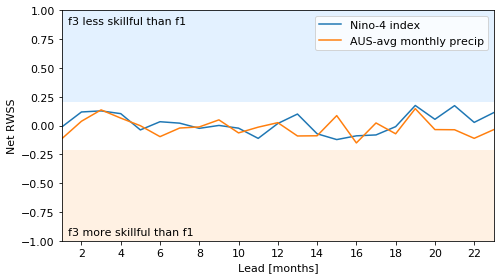

In [132]:
linewidth = 2
fontsize = 11
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(10,4))
axes_locs = [[0,0.5,0.6,0.8]] #,[0.5,0.5,0.44,0.8]] #,[1.02,0.5,0.29,0.8]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))

# Nino-4 ==============================================================
anom = 'c1'
ref = f3_nino4['f3_' + anom]
obs = had_nino4['had_' + anom]
model = f1_nino4['f1_' + anom]
model_name = 'f1'

ax = axes[0]
sign_test = doppyo.skill.sign_test(ref.mean('ensemble'), 
                                   model.mean('ensemble'), 
                                   obs.sel(init_date=slice('1999','2015')))

sign_masked = sign_test[0].fillna(0)
conf_masked = sign_test[1].fillna(0)
norm = ((1 + 0*sign_masked).sum('init_date') ** 2 + (1 + 0*sign_masked).sum('init_date')) / 2
sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                   x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm
conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                   x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm

ax.fill_between(conf_area.lead_time,
                    -1 * conf_area, conf_area, color=grey, label='_nolegend_')
ax.plot(sign_area.lead_time, -sign_area, label=model_name)

# Shade regions ------
ax.set_ylim(-1,1)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                 facecolor=upper_color, linewidth=0.0, zorder=0)
ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                 facecolor=lower_color, linewidth=0.0, zorder=0)

ax.set_xlim(1,23)
ax.set_xticks(np.arange(2,24,2))

ax.text(1.3,0.88,'f3 less skillful than f1', fontsize=fontsize)
ax.text(1.3,-0.95,'f3 more skillful than f1', fontsize=fontsize);

# Precip ==============================================================
anom = 'c1'
ref = f3_precip['f3_' + anom].mean(['lat','lon'])
model = f1_precip['f1_' + anom].mean(['lat','lon'])
obs = jra_precip['jra_' + anom].interp(lat=f3_precip.lat, lon=f3_precip.lon).mean(['lat','lon'])
model_name = 'f1'

sign_test = doppyo.skill.sign_test(ref.mean('ensemble'), 
                                   model.mean('ensemble'), 
                                   obs.sel(init_date=slice('1999','2015')))

sign_masked = sign_test[0].fillna(0)
conf_masked = sign_test[1].fillna(0)
norm = ((1 + 0*sign_masked).sum('init_date') ** 2 + (1 + 0*sign_masked).sum('init_date')) / 2
sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                   x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm
conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                   x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm

ax.fill_between(conf_area.lead_time,
                    -1 * conf_area, conf_area, color=grey, label='_nolegend_')
ax.plot(sign_area.lead_time, -sign_area, label=model_name)

# Shade regions ------
ax.set_ylim(-1,1)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                 facecolor=upper_color, linewidth=0.0, zorder=0)
ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                 facecolor=lower_color, linewidth=0.0, zorder=0)

ax.set_ylabel('Net RWSS')
ax.set_xlim(1,23)
ax.set_xticks(np.arange(2,24,2))
ax.set_xlabel('Lead [months]');
ax.legend(['Nino-4 index','AUS-avg monthly precip']);

plt.savefig(saveloc + 'nRWSS_f3vf1_Nino4_precip.eps', format='eps', bbox_inches='tight')
# plt.savefig(saveloc + 'nino4_randomwalk_f3vf1_allseasons.png', format='png', bbox_inches='tight')